# Brain Tumor Image Classification Using Convolutional Neural Networks

**We  are going installs the kaggle package to access and download datasets directly from Kaggle using Kaggle API**



In [1]:
!pip install kaggle

This is the API command provided by Kaggle. Lets us downloa the dataset in a zip format

In [ ]:
!kaggle datasets download -d pkdarabi/brain-tumor-image-dataset-semantic-segmentation -p /content/drive/MyDrive/Brain_Tumor/


Dataset URL: https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation
License(s): Attribution 4.0 International (CC BY 4.0)
brain-tumor-image-dataset-semantic-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


**Since i dowloaded my dataset in my google drive Brain Tumor folder we are going to extract or unzip the folder in the same location**

In [ ]:
!unzip /content/drive/MyDrive/Brain_Tumor/brain-tumor-image-dataset-semantic-segmentation.zip -d /content/drive/MyDrive/Brain_Tumor/

Archive:  /content/drive/MyDrive/Brain_Tumor/brain-tumor-image-dataset-semantic-segmentation.zip
replace /content/drive/MyDrive/Brain_Tumor/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Installing pycocotools package
# We will use it to load the coco format annotations of the images
# Will allows us to get info abot the images like the classes the images belong to
!pip install pycocotools


## Exploratory Data Analysis

In [2]:
#  Will now load the json files from each folder


import json
import os

# Define paths to each JSON file
base_path = '/content/drive/MyDrive/Brain_Tumor'
train_json_path = os.path.join(base_path, 'train', '_annotations.coco.json')
test_json_path = os.path.join(base_path, 'test', '_annotations.coco.json')
valid_json_path = os.path.join(base_path, 'valid', '_annotations.coco.json')

# Function to load JSON data
def load_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

# Loading each JSON file
train_data = load_json(train_json_path)
test_data = load_json(test_json_path)
valid_data = load_json(valid_json_path)


In [3]:
# Lets inspect the structure of the JSON data

print(train_data.keys())  # This will give us the main keys of the JSON file (usually 'images', 'annotations', etc.)

# Accessing some example images and annotations
print(train_data['images'][0])  # This will print the first image information

print(train_data['annotations'][0])  # This will print the first annotation information


dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
{'id': 0, 'license': 1, 'file_name': '2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}
{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [145, 239, 168.75, 162.5], 'area': 27421.875, 'segmentation': [[313.75, 238.75, 145, 238.75, 145, 401.25, 313.75, 401.25, 313.75, 238.75]], 'iscrowd': 0}


From the above code the JSON files are in a typical COCO format which consist of the the following main components:



*   info
*   licenses
*   categories ( this describes the classes of the images(tumor or no tumor)
*   images
* annoations



In [4]:


# Display all categories to understand what each ID represents
#
for category in train_data['categories']:
    print(f"ID: {category['id']}, Name: {category['name']}")


ID: 0, Name: Tumor
ID: 1, Name: 0
ID: 2, Name: 1


From this its not very clear what  ID 1 and 2 stand for so we are going to further investigate

In [ ]:
# Filter and display annotations for each category to see what they refer to
for category_id in [0, 1, 2]:
    print(f"\nAnnotations for Category ID: {category_id}")
    category_annotations = [ann for ann in train_data['annotations'] if ann['category_id'] == category_id]
    for annotation in category_annotations[:5]:  # Display first 5 annotations of each type
        print(annotation)



Annotations for Category ID: 0

Annotations for Category ID: 1
{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [145, 239, 168.75, 162.5], 'area': 27421.875, 'segmentation': [[313.75, 238.75, 145, 238.75, 145, 401.25, 313.75, 401.25, 313.75, 238.75]], 'iscrowd': 0}
{'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [194, 176, 148.75, 233.75], 'area': 34770.313, 'segmentation': [[342.5, 176.25, 193.75, 176.25, 193.75, 410, 342.5, 410, 342.5, 176.25]], 'iscrowd': 0}
{'id': 2, 'image_id': 2, 'category_id': 1, 'bbox': [133, 173, 162.5, 185], 'area': 30062.5, 'segmentation': [[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295, 357.5, 295, 172.5]], 'iscrowd': 0}
{'id': 3, 'image_id': 3, 'category_id': 1, 'bbox': [245, 358, 138.75, 166.25], 'area': 23067.188, 'segmentation': [[383.75, 357.5, 245, 357.5, 245, 523.75, 383.75, 523.75, 383.75, 357.5]], 'iscrowd': 0}
{'id': 4, 'image_id': 4, 'category_id': 1, 'bbox': [80, 189, 112.5, 132.5], 'area': 14906.25, 'segmentation': [[192.5, 188.75, 80, 188.

Based on what we obtaned ID:0 has no annotations so it might be an unsused category



*   ID 1 : contains annotations for images likely to represent Tumors
*   ID 2 : also contains annotations of normal brainn images(without any tumors)



We are now going to convert the JSON annotations into a pandas dataframe.
This will allow us to manipulate data and train models easily

We will take the file name, category id and the category name

** We will convert the annotations for train,test and valid data

In [5]:
# dataframe annotations for train

import pandas as pd

def extract_annotations(json_data):
    images_info = json_data['images']
    annotations_info = json_data['annotations']
    categories_info = json_data['categories']

    # Create a mapping from category IDs to category names
    category_map = {cat['id']: cat['name'] for cat in categories_info}

    # Map each image ID to its file name
    image_map = {img['id']: img['file_name'] for img in images_info}

    # Prepare a list to store the data
    data = []

    for ann in annotations_info:
        img_id = ann['image_id']
        category_id = ann['category_id']
        file_name = image_map[img_id]
        category_name = category_map[category_id]

        # Add data as a tuple (image path, category ID, category name)
        data.append((file_name, category_id, category_name))

    # Convert to a DataFrame for easier handling
    df = pd.DataFrame(data, columns=['file_name', 'category_id', 'category_name'])
    return df

# Extract annotations for train data (repeat similarly for test and validation)
train_annotations_df = extract_annotations(train_data)
print(train_annotations_df.head())


                                          file_name  category_id category_name
0  2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg            1             0
1  2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg            1             0
2  2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg            1             0
3  2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg            1             0
4  2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg            1             0


In [8]:
# dataframe annotations for validate data
import pandas as pd

def extract_annotations_2(json_data):
    images_info = json_data['images']
    annotations_info = json_data['annotations']
    categories_info = json_data['categories']

    # Create a mapping from category IDs to category names
    category_map = {cat['id']: cat['name'] for cat in categories_info}

    # Map each image ID to its file name
    image_map = {img['id']: img['file_name'] for img in images_info}

    # Prepare a list to store the data
    data = []

    for ann in annotations_info:
        img_id = ann['image_id']
        category_id = ann['category_id']
        file_name = image_map[img_id]
        category_name = category_map[category_id]

        # Add data as a tuple (image path, category ID, category name)
        data.append((file_name, category_id, category_name))

    # Convert to a DataFrame for easier handling
    df2 = pd.DataFrame(data, columns=['file_name', 'category_id', 'category_name'])
    return df2

# Extract annotations for train data (repeat similarly for test and validation)
valid_annotations_df = extract_annotations_2(valid_data)
print(valid_annotations_df.head())

                                          file_name  category_id category_name
0  1997_jpg.rf.57e306420710246d04c0d5c26e6496c6.jpg            1             0
1  2422_jpg.rf.59a35b6d8d2eed150af8535cf09bbde5.jpg            1             0
2  1630_jpg.rf.5afc6e25d7987503a11bcb0791b60b53.jpg            2             1
3  1330_jpg.rf.5b23bf18a29b0f50e376b19a5a84f823.jpg            2             1
4  2768_jpg.rf.5b87c0023909e0789a33185a3aab92e9.jpg            1             0


In [6]:
# dataframe for test data annotations
import pandas as pd

def extract_annotations_3(json_data):
    images_info = json_data['images']
    annotations_info = json_data['annotations']
    categories_info = json_data['categories']

    # Create a mapping from category IDs to category names
    category_map = {cat['id']: cat['name'] for cat in categories_info}

    # Map each image ID to its file name
    image_map = {img['id']: img['file_name'] for img in images_info}

    # Prepare a list to store the data
    data = []

    for ann in annotations_info:
        img_id = ann['image_id']
        category_id = ann['category_id']
        file_name = image_map[img_id]
        category_name = category_map[category_id]

        # Add data as a tuple (image path, category ID, category name)
        data.append((file_name, category_id, category_name))

    # Convert to a DataFrame for easier handling
    df3 = pd.DataFrame(data, columns=['file_name', 'category_id', 'category_name'])
    return df3

# Extract annotations for train data (repeat similarly for test and validation)
test_annotations_df = extract_annotations_3(test_data)
print(test_annotations_df.head())

                                          file_name  category_id category_name
0  1706_jpg.rf.004b87f63425ef145855aab826e33eee.jpg            2             1
1  1363_jpg.rf.01c4537b57f360820b9e00c7e0c99ae1.jpg            2             1
2  1136_jpg.rf.02df64849485272e48139498c36c8e44.jpg            2             1
3  2210_jpg.rf.039c38182fe783c69dd28160e5ef02a0.jpg            1             0
4  2058_jpg.rf.04e8e79db0fbf2459585ce3954f50739.jpg            1             0


In [9]:
# we can then save the annotations to a csv or excell file

train_annotations_df.to_csv('/content/drive/MyDrive/Brain_Tumor/train_annotations.csv', index=False)
test_annotations_df.to_csv('/content/drive/MyDrive/Brain_Tumor/test_annotations.csv', index=False)
valid_annotations_df.to_csv('/content/drive/MyDrive/Brain_Tumor/valid_annotations.csv', index=False)


In [10]:
train_annotations_df.to_excel('/content/drive/MyDrive/Brain_Tumor/train_annotations.xlsx', index=False)
test_annotations_df.to_excel('/content/drive/MyDrive/Brain_Tumor/test_annotations.xlsx', index=False)
valid_annotations_df.to_excel('/content/drive/MyDrive/Brain_Tumor/valid_annotations.xlsx', index=False)

## LOAD AND PREPROCESSING IMAGES(TRAIN, VALIDATION TEST SETS)

Now that we have extracted the annotations and converted them into dataframes for easy use we can now preprocess the images for model training

**Load and Resize Images:**  we need to resize our images to be of consistent size because neural networks require images of a consistent size(can resize all images to a standard shape, like 128x128 or 224x224)

**Normalize Pixel Values:** To help the neural network learn more effectively we are also going to scale the pixel values between 0 and 1

**Label Encoding:** Last step will be to map the category names to numeric labels. We will use **category_id**

In [ ]:
# Preprocessing code
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define directories for each dataset
TRAIN_DIR = '/content/drive/MyDrive/Brain_Tumor/train'
VALID_DIR = '/content/drive/MyDrive/Brain_Tumor/valid'
TEST_DIR = '/content/drive/MyDrive/Brain_Tumor/test'

# Define a function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img_array

# Load images and labels for each dataset
train_image_paths = [os.path.join(TRAIN_DIR, fname) for fname in train_annotations_df['file_name']]
valid_image_paths = [os.path.join(VALID_DIR, fname) for fname in valid_annotations_df['file_name']]
test_image_paths = [os.path.join(TEST_DIR, fname) for fname in test_annotations_df['file_name']]

# Preprocess images for each dataset
train_images = np.array([load_and_preprocess_image(path) for path in train_image_paths])
valid_images = np.array([load_and_preprocess_image(path) for path in valid_image_paths])
test_images = np.array([load_and_preprocess_image(path) for path in test_image_paths])

# Load labels for each dataset
train_labels = train_annotations_df['category_id'].values
valid_labels = valid_annotations_df['category_id'].values
test_labels = test_annotations_df['category_id'].values


## MODEL ARCHITECTURE

Now we define a CNN model with convolutional and pooling layers together with dense layers for classification

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model(input_shape=(128, 128, 3), num_classes=3):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Fourth Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and Fully Connected Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Create the model
model = create_model(input_shape=(128, 128, 3), num_classes=3)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,602,179 (9.93 MB)

 Trainable params: 2,602,179 (9.93 MB)

 Non-trainable params: 0 (0.00 B)

## MODEL TRAINING

Will now train the model using the preprocessed images and lables.

number of epochs and batch size will be specified

In [ ]:
# Train the model
history = model.fit(train_images, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(valid_images, valid_labels))




Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9983 - loss: 0.0111 - val_accuracy: 0.9930 - val_loss: 0.0296
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9966 - loss: 0.0115 - val_accuracy: 0.9907 - val_loss: 0.0263
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9921 - loss: 0.0168 - val_accuracy: 0.9907 - val_loss: 0.0304
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9905 - loss: 0.0226 - val_accuracy: 0.9837 - val_loss: 0.0548
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9932 - loss: 0.0227 - val_accuracy: 0.9837 - val_loss: 0.0266
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9984 - loss: 0.0083 - val_accuracy: 0.9883 - val_loss: 0.0301
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9976 - loss: 0.0059 - val_accuracy: 0.9883 - val_loss: 0.0469
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9992 - loss: 0.0015 - val_accuracy: 0.9930 - v

## MODEL EVALUATION

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")


7/7 - 1s - 197ms/step - accuracy: 0.9814 - loss: 0.1903
Test accuracy: 0.9813953638076782


### Classification report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming 'model' is your trained model and 'test_images' is your test data
# Get predictions (these will be probabilities for each class)
pred_probs = model.predict(test_images)

# Convert probabilities to class labels
y_pred = np.argmax(pred_probs, axis=1)

# Check if test_labels is one-dimensional
if len(test_labels.shape) == 1:
    y_true = test_labels  # Use directly if it's already a single label format
else:
    y_true = np.argmax(test_labels, axis=1)  # Convert one-hot encoded labels to single labels if they are in that format

# Print the classification report
print(classification_report(y_true, y_pred, target_names=['Category 1', 'Category 2']))



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

  Category 1       0.99      0.97      0.98       118
  Category 2       0.97      0.99      0.98        97

    accuracy                           0.98       215
   macro avg       0.98      0.98      0.98       215
weighted avg       0.98      0.98      0.98       215



### CONFUSION MATRIX

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


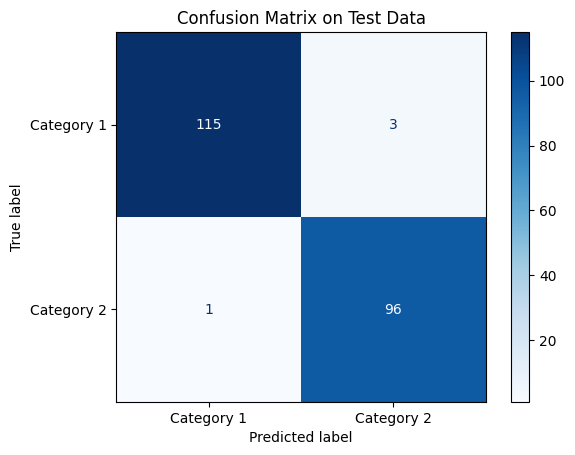

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
y_pred = np.argmax(model.predict(test_images), axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Category 1", "Category 2"])
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Data")
plt.show()

### TRAIN vs VALIDATION PLOT

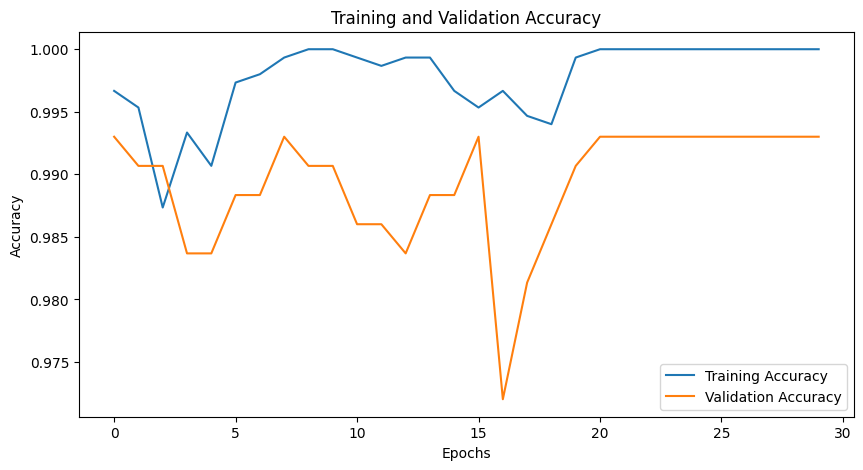

In [ ]:
# Plot training & validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# CONCLUSION

The resluts obtained show that model acieved very high or near perfect training accuarcy arround 100% and very high validation accuracy of 99.30%. The validation loss was fluctuation of the number of epochs the model was trained for.

From the visualisation specifically the confusion matrix we were able to see how the model performed across the different classes.

**Did our model overfit or underfit? :**

Well it did not overfit or underfit because the trainning accuracy and test accuracy are very close. The confusion matrix also serves as a backup to whether the model overfit or not of course in combination with other metrics.